In [1]:
# base imports
import time
from collections import defaultdict
%matplotlib inline
import pandas as pd
from copy import copy
from matplotlib import pyplot as plt
import matplotlib as mpl
import numpy as np
import pytz
tz = pytz.timezone("US/Pacific")

In [2]:
# for fetching data
from xbos import get_client
from xbos.services.pundat import DataClient, timestamp, make_dataframe, merge_dfs
from xbos.services.hod import HodClient

In [57]:
# get a bosswave client
c = get_client(entity="/Users/Daniel/CIEE/SetUp/ciee_readonly.ent", agent="127.0.0.1:28589")
# get a HodDB client
hod = HodClient("ciee/hod", c)
# get an archiver client
archiver = DataClient(c,archivers=["ucberkeley"])

Saw [ciee/hod] HodDB 3 seconds 74.973 ms ago
Saw [ucberkeley] archiver 7 seconds 313.187 ms ago


In [58]:
# define a Brick query to get the temperature information
q = """SELECT ?x ?hvaczone ?uuid WHERE { 
?x bf:controls/bf:feeds ?hvaczone .
 ?hvaczone rdf:type brick:HVAC_Zone .
?x rdf:type/rdfs:subClassOf* brick:Thermostat .
  ?x bf:hasPoint ?status .
  ?status rdf:type brick:Thermostat_Status .
  ?status bf:uuid ?uuid .
};
"""
res = hod.do_query(q)['Rows']
zones = defaultdict(lambda: defaultdict(list))
for sensor in res:
    zones[sensor["?hvaczone"]]["Heating"].append(sensor["?uuid"])


In [59]:
# define a Brick query to get the occupancy information
q = """SELECT ?zone ?sensor_uuid WHERE {
   ?zone rdf:type brick:HVAC_Zone .
   ?zone bf:hasPart ?room .
   ?sensor bf:isLocatedIn ?room .
   ?sensor rdf:type/rdfs:subClassOf* brick:Occupancy_Sensor .
   ?sensor bf:uuid ?sensor_uuid .
};
"""
res = hod.do_query(q)['Rows']
for sensor in res:
    zones[sensor['?zone']]["Occupancy"].append(sensor['?sensor_uuid'])

In [60]:
test_zones = {"Test": {"Occupancy": pd.DataFrame([[0, 0, 0], [1,0,0]], columns=["f", "s", "t"], index=[0, 1]), "Heating":pd.DataFrame([[1], [0]], columns=["f"], index=[0,1])}}

In [61]:
# timestamps for data retrieval
start = '"2017-09-01 08:00:00 MST"'
end = '"2017-09-08 08:00:00 MST"'

test = False
if test:
    zones = test_zones

# loop to get data for time spent while (heating and occupied), (heating and not occupied), (not heating and occupied),
# (not heating and not occupied)
print("Loop has started")
zone_ho = {}
for zone, values in zones.items():
    t = time.time()
    # unpack data from the values in dictionary
    heating = values["Heating"]
    occupancy = values["Occupancy"]
    print(occupancy)
    # get data from archiver
    if not test:
        heating_data = make_dataframe(archiver.data_uuids(heating, start, end))
        occupancy_data = make_dataframe(archiver.data_uuids(occupancy, start, end))
        # merge the retrieved data into an acceptable dfs
        heating_dfs = merge_dfs(heating_data, resample="30S", do_max=True)
        occupancy_dfs = merge_dfs(occupancy_data, resample="30S", do_max=True)
        # set the occupany dfs to reflect is someone is in (1) or not (0)
        occupancy_dfs = 1*(occupancy_dfs > 0)
    if test:
        occupancy_dfs = occupancy
        heating_dfs = heating
    # change the column names to make them more easy to identify 
    occupancy_dfs.columns = occupancy_dfs.columns.map(lambda x: "occupancy_"+str(x))
    heating_dfs.columns = heating_dfs.columns.map(lambda x: "heating_" + str(x))
    # concatinating the two dfs. Might be not so good because of the timeseries. Might have to resample i suppose or
    # do something about it.
    data = pd.concat([heating_dfs, occupancy_dfs], axis=1)
    # function for a row of the data. Returns the four information sets accordingly
    criteria_heating = data.columns.map(lambda y: "heating" in y).tolist()
    criteria_occupancy = data.columns.map(lambda z: "occupancy" in z).tolist()
    def f(x):
        occupied = any(x[criteria_occupancy])
        heating = any(x[criteria_heating])
        return pd.Series([occupied and heating, not occupied and heating, occupied and not heating, not occupied and not heating])
    heating_occupancy = data.apply(f, axis=1)
    heating_occupancy.columns = pd.Series(["o&h", "no&h", "o&nh", "no&nh"])
    zone_ho[zone] = heating_occupancy
    print("Time for " + str(zone) + " was: " + str(time.time()-t))
print("Done with cleaning up data.")
    

Loop has started
['d919a14e-3ebd-3e5b-9727-0df54f287032', 'cab606d0-6d14-3aff-a0c2-e862ae297f22', 'c27adbad-b1b5-342c-91eb-a6709d365871', 'bdbbbf7c-21c3-3b61-8469-8516a8c666dd', 'afed35be-ef70-341a-8bf4-565d815bfd90', 'aefa14ef-a13a-355b-9b87-51511db7f541', '989ed503-9aa2-310e-abd3-464f6169e175', '97ba99af-869b-3c43-94e3-93040c9bdd33', '611ac5e9-33a5-3273-9fa6-548d3ad59481', '497145c4-2087-3e89-9c8f-f54b87dfb016', '47e37419-5091-3877-a476-bb6f942e93af', '2f5c888d-c0c6-33b4-9c30-d609f1e16fea', '2b3f9905-3bb7-302a-9545-7bfe2eb63547', '242cde13-7d25-306a-bfc8-918ad7bb26d6', '23d2afce-4c86-37c5-b1c2-f258758c3263', '0c51371e-6029-3302-984d-b71d850e899a', '00f45f05-08f9-3def-a977-357493fad61e']
Time for SouthZone was: 27.9848799706
['c2c477b4-c02c-32cc-9334-81fe419d0e81']
Time for NorthZone was: 17.8803908825
['3cea0629-6fcd-3c6a-9786-7b571eaaf13d', 'f91e8678-47a2-3da6-9eec-753f4364044c', 'f5994eac-9691-36a6-8610-599aa3ecbd36', 'f3262678-43d5-39ab-ab42-13abd3c952f9', 'c5fefca9-58b3-37b5-ba10

Times for: SouthZone in hours:
o&h       12.450000
no&h      14.766667
o&nh      25.208333
no&nh    115.575000
dtype: float64
Times for: NorthZone in hours:
o&h        0.991667
no&h      25.300000
o&nh       1.308333
no&nh    140.400000
dtype: float64
Times for: CentralZone in hours:
o&h        7.866667
no&h      14.875000
o&nh      33.100000
no&nh    112.158333
dtype: float64
Times for: EastZone in hours:
o&h        1.791667
no&h      50.458333
o&nh      12.016667
no&nh    103.733333
dtype: float64


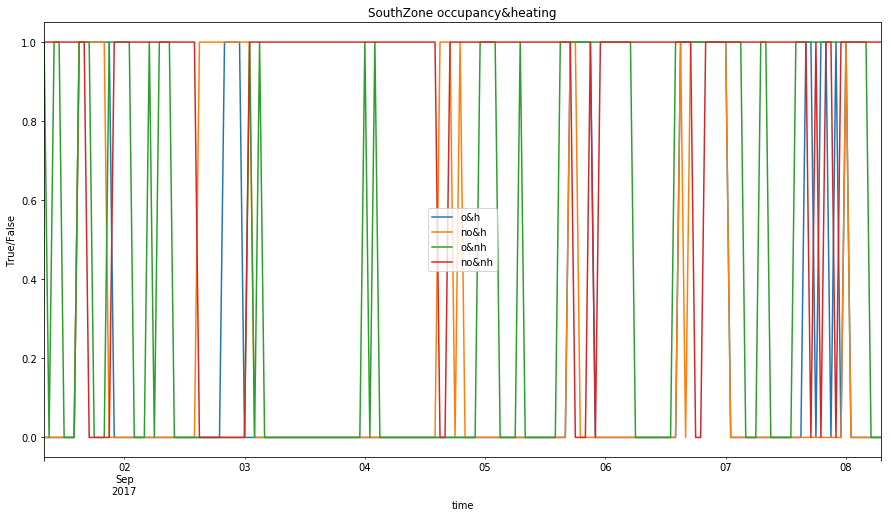

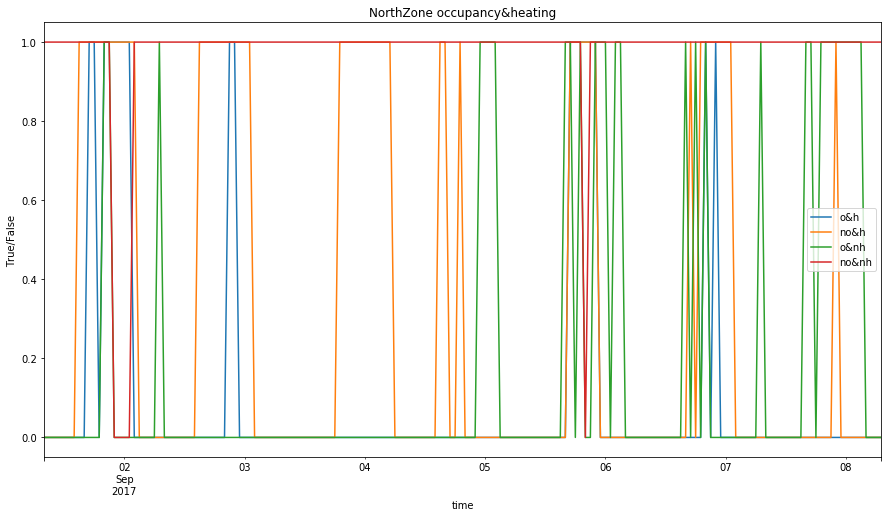

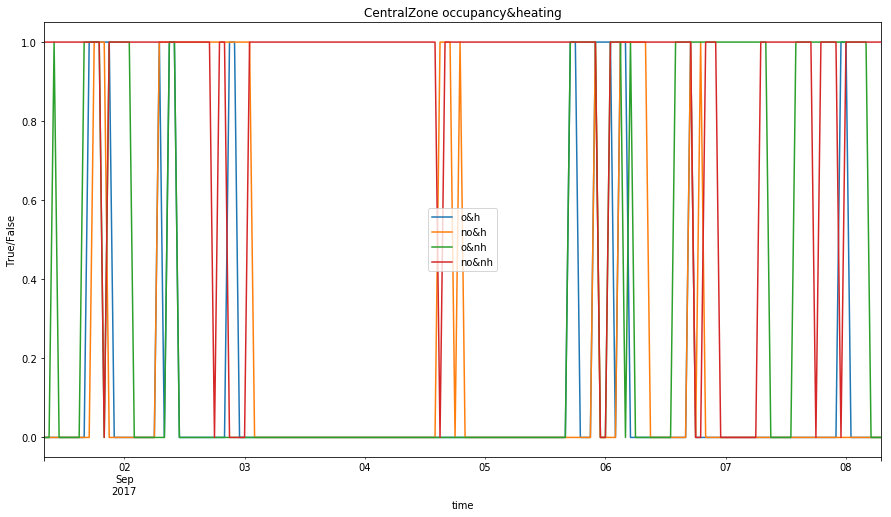

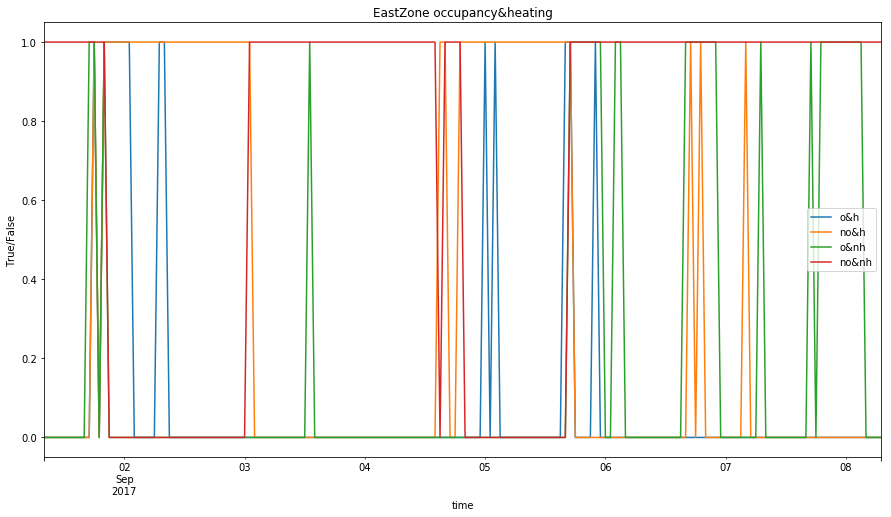

In [62]:
for zone, heating_occupancy in zone_ho.items():
    time_spent = heating_occupancy.sum(axis=0) * 0.5 / 60
    print("Times for: " + str(zone) + " in hours:")
    print(time_spent)
#     print("Ratio: "+str(time))
    figure = heating_occupancy.resample("1H").max().plot(legend=True, figsize=(15,8))
    figure.set_title(zone+ " occupancy&heating")
    figure.set_ylabel("True/False")

# Find histogram of occupancy

In [4]:
# define a Brick query to get the occupancy information
q = """SELECT ?zone ?sensor_uuid WHERE {
   ?zone rdf:type brick:HVAC_Zone .
   ?zone bf:hasPart ?room .
   ?sensor bf:isLocatedIn ?room .
   ?sensor rdf:type/rdfs:subClassOf* brick:Occupancy_Sensor .
   ?sensor bf:uuid ?sensor_uuid .
};
"""
result = hod.do_query(q)['Rows']
occupancy_sensors = defaultdict(list)
for sensor in result:
    occupancy_sensors[sensor['?zone']].append(sensor['?sensor_uuid'])

In [18]:
"""Need a function by which to sort to put in the days. We will put those days in a histogram then. 
We will have several histograms one for each zone."""
# function = lambda x: x
# histogram = {}
start = '"2017-09-01 00:00:00 MST"'
end = '"2017-09-10 00:00:00 MST"'
time_steps = "15T"
zone_df = defaultdict()
for zone, sensor_uuid in occupancy_sensors.items():
    occupancy_data = make_dataframe(archiver.data_uuids(sensor_uuid, start, end))
    occupancy_df = merge_dfs(occupancy_data, resample=time_steps, do_max=True)
    zone_df[zone] = 1*(occupancy_df > 0)
    idx = zone_df[zone].index
    idx = idx.tz_localize(pytz.utc).tz_convert(tz)
    zone_df[zone].index = idx
    # we are gonna assume a function, which returns True if this date should be used

In [19]:
# for zone basis
reduced_data_zones = {}
for key, value in zone_df.items():
    reduced_data_zones[key] = value.apply(lambda x: max(x), axis = 1) 

In [20]:
reduced_data_building = None
for key, value in zone_df.items():
    if reduced_data_building is None:
        reduced_data_building = value
    else:
        reduced_data_building = pd.concat([reduced_data_building, value], axis=1)
reduced_data_building = reduced_data_building.apply(lambda x: max(x), axis=1)    

In [43]:
start = pd.to_datetime("08:00:00").time()
end = pd.to_datetime("18:00:00").time()
current_schedule = pd.Series(index=zone_df["SouthZone"].index)
current_schedule = pd.Series(current_schedule.reset_index().apply(lambda x: x['time'].time() >= start and x['time'].time() <= end, axis=1).values, index = zone_df["SouthZone"].index)
current_schedule = 1*(current_schedule)

In [22]:
def hamming_dis(arr):
    return np.sum(np.square(arr - current_schedule))

In [51]:
# set the condition with which to filter the dates in the range
# test every monday
cond = lambda x: True #x.weekday() == 1

In [55]:
# # on a zone basis
# use_here = reduced_data_zones["SouthZone"][reduced_data_zones["SouthZone"].index.map(cond)]
# print(use_here.resample("1D").apply(hamming_dis))

# on a room basis
for key, value in reduced_data_zones.items():
    use_here = reduced_data_zones[key][reduced_data_zones[key].index.map(cond)]
    use_here = use_here.resample("1D").apply(hamming_dis)
    print(key)
    print(use_here)

SouthZone
time
2017-08-31 00:00:00-07:00    13.0
2017-09-01 00:00:00-07:00    13.0
2017-09-02 00:00:00-07:00    38.0
2017-09-03 00:00:00-07:00    42.0
2017-09-04 00:00:00-07:00    39.0
2017-09-05 00:00:00-07:00    22.0
2017-09-06 00:00:00-07:00    11.0
2017-09-07 00:00:00-07:00    18.0
2017-09-08 00:00:00-07:00    11.0
2017-09-09 00:00:00-07:00    36.0
Freq: D, dtype: float64
CentralZone
time
2017-08-31 00:00:00-07:00     9.0
2017-09-01 00:00:00-07:00    11.0
2017-09-02 00:00:00-07:00    44.0
2017-09-03 00:00:00-07:00    41.0
2017-09-04 00:00:00-07:00    41.0
2017-09-05 00:00:00-07:00    18.0
2017-09-06 00:00:00-07:00    32.0
2017-09-07 00:00:00-07:00    18.0
2017-09-08 00:00:00-07:00     5.0
Freq: D, dtype: float64
NorthZone
time
2017-08-31 00:00:00-07:00     3.0
2017-09-01 00:00:00-07:00    25.0
2017-09-02 00:00:00-07:00    39.0
2017-09-03 00:00:00-07:00    41.0
2017-09-04 00:00:00-07:00    39.0
2017-09-05 00:00:00-07:00    14.0
2017-09-06 00:00:00-07:00    31.0
2017-09-07 00:00:00-0

In [16]:
# on a building basis
use_here = reduced_data_building[reduced_data_building.index.map(cond)]
use_here.resample("1D").apply(hamming_dis)

time
2017-09-04 00:00:00-07:00    601.0
Freq: D, dtype: float64

In [54]:
# on a room basis
for key, value in zone_df.items():
    use_here = zone_df[key][zone_df[key].index.map(cond)]
    use_here = use_here.resample("1D").apply(hamming_dis)
    print(key)
    print(use_here)

SouthZone
                           2f5c888d-c0c6-33b4-9c30-d609f1e16fea_value  \
time                                                                    
2017-08-31 00:00:00-07:00                                         5.0   
2017-09-01 00:00:00-07:00                                        29.0   
2017-09-02 00:00:00-07:00                                        45.0   
2017-09-03 00:00:00-07:00                                        41.0   
2017-09-04 00:00:00-07:00                                        41.0   
2017-09-05 00:00:00-07:00                                        28.0   
2017-09-06 00:00:00-07:00                                        24.0   
2017-09-07 00:00:00-07:00                                        33.0   
2017-09-08 00:00:00-07:00                                        31.0   
2017-09-09 00:00:00-07:00                                        36.0   

                           497145c4-2087-3e89-9c8f-f54b87dfb016_value  \
time                                    

In [150]:
# Find histogram for when people come and leave
def come_go(arr):
    arr = arr.loc[pd.to_datetime("03:00:00").time():pd.to_datetime("21:00:00").time()]
    come = arr.idxmax()
    go = arr[::-1].idxmax()
    return pd.DataFrame([[come, go]], columns=["come", "go"])

In [160]:
# on a building basis
use_here = reduced_data_building[reduced_data_building.index.map(cond)]
result = use_here.resample("1D").apply(come_go)
print(result)

2017-09-01 21:00:00
2017-09-01 21:00:00
2017-09-02 20:59:00
2017-09-03 13:02:00
2017-09-04 21:00:00
2017-09-05 21:00:00
2017-09-06 21:00:00
2017-09-07 21:00:00
2017-09-08 21:00:00
2017-09-09 21:00:00
time
2017-09-01                     come                  go
0 20...
2017-09-02                     come                  go
0 20...
2017-09-03                     come                  go
0 20...
2017-09-04                     come                  go
0 20...
2017-09-05                     come                  go
0 20...
2017-09-06                     come                  go
0 20...
2017-09-07                     come                  go
0 20...
2017-09-08                     come                  go
0 20...
2017-09-09                     come                  go
0 20...
dtype: object


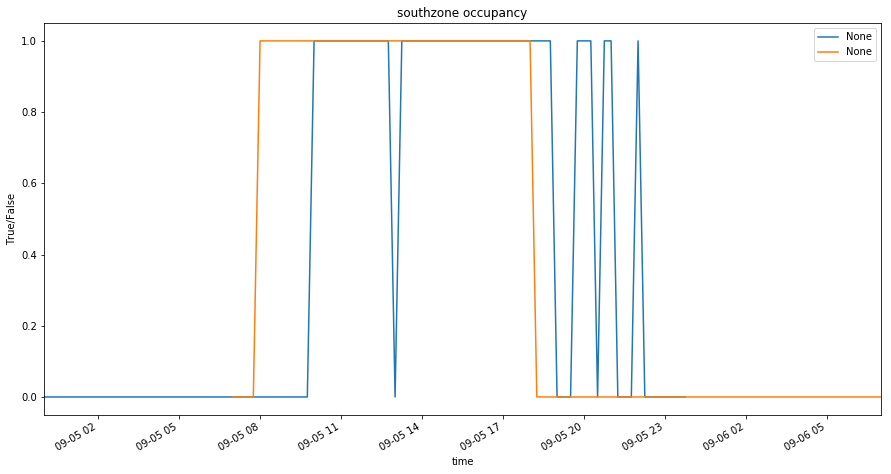

In [50]:
# set the condition with which to filter the dates in the range
# test every monday
cond = lambda x: x.weekday() == 1

# Plot occupancy in building throughout a day
use_here = reduced_data_zones["CentralZone"][reduced_data_zones["CentralZone"].index.map(cond)]
figure = use_here.resample("15T").max().plot(legend=True, figsize=(15,8))
figure.set_title("southzone" + " occupancy")
figure.set_ylabel("True/False")
ax = figure.get_axes()
temp_schedule = current_schedule.loc[pd.to_datetime("2017-09-05 00:00:00 PST"): pd.to_datetime("2017-09-06 00:00:00 PST")]
current_figure = temp_schedule.resample("15T").max().plot(legend = True, ax=ax)

# pd.to_datetime("2017-09-04 00:00:00 PST"), pd.to_datetime("2017-09-05 00:00:00 PST")

In [133]:
pd.to_datetime("07:00:00").time()

datetime.time(7, 0)

In [158]:
pd.to_datetime("2017, 1, 9")

Timestamp('2017-01-09 00:00:00')